<a href="https://colab.research.google.com/github/luuloi/GWAS_Introduction_2023/blob/main/gwas_quantitative_traits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare session by install necessary packages

In [26]:
!pip install rpy2
!pip install -q condacolab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 14.7 MB/s eta 0:00:00
  Created wheel for rpy2: filename=rpy2-3.5.13-cp310-cp310-linux_x86_64.whl size=262728 sha256=604b7a6fb4c9c2c27a22f38a29a4f0187eb3442f5cc520fac7ff88eb2bcffcd7
  Stored in directory: /root/.cache/pip/wheels/b3/10/14/333faaf40f9cd461b2cd5a785a32d593b88e08b1834f081bd5
Successfully built rpy2


In [27]:
# Ignore rpy2's warnings

import warnings
from rpy2.rinterface import RRuntimeWarning

warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [28]:
# Initialize conda

import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [43]:
# Install plink, bedtools

!conda install -c bioconda plink
!conda install -c bioconda bedtools

Solving environment: - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2



# All requested packages already installed.

Solving environment: \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bedtools


The following packages will be downloaded:

    package                    |            build
    ---------

# Set up R environment by installing required packages.

Load `rpy2`

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


`pacman` will make your life easier and I have include `BiocManager` for bio-oriented packages.

In [31]:
%%R
if (!require("pacman")) install.packages("pacman")
library("pacman")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Function to check and install missing packages
check_and_install_packages <- function(packages) {
    for (package in packages) {
        if (!require(package, character.only = TRUE)) {
            if (package %in% rownames(available.packages(repos = BiocManager::repositories())))
                BiocManager::install(package, character.only = TRUE)
        else
            install.packages(package, character.only = TRUE)
        require(package, character.only = TRUE)
        }
    }
}

R[write to console]: Loading required package: pacman



We will use the following packages for today lecture.

* [qqman](https://cran.r-project.org/web/packages/qqman/vignettes/qqman.html)
* [SKAT](https://cran.r-project.org/web/packages/SKAT/index.html)
* [GWASTools](https://bioconductor.org/packages/release/bioc/manuals/GWASTools/man/GWASTools.pdf)
* [gdsfmt](https://bioconductor.org/packages/release/bioc/manuals/gdsfmt/man/gdsfmt.pdf)
* [SNPRelate](https://www.bioconductor.org/packages/release/bioc/manuals/SNPRelate/man/SNPRelate.pdf)
* [GENESIS](https://bioconductor.org/packages/release/bioc/manuals/GENESIS/man/GENESIS.pdf)

In [32]:
%%R
check_and_install_packages(c("qqman", "SKAT", "GWASTools", "SNPRelate", "GENESIS"))

R[write to console]: Loading required package: qqman

R[write to console]: 

R[write to console]: For example usage please run: vignette('qqman')

R[write to console]: 

R[write to console]: Citation appreciated but not required:

R[write to console]: Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

R[write to console]: 

R[write to console]: Loading required package: SKAT

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: SPAtest

R[write to console]: Loading required package: RSpectra

R[write to console]: Loading required package: GWASTools

R[write to console]: Loading required package: Biobase

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, s

# Load data

Read directly from URL

In [33]:
%%R
# Function to read and display data
read_and_display <- function(file_path, col_names=NULL, sep=" ", header=FALSE) {
  data <- read.table(file=file_path, sep=sep, header=header, na.strings="NA")
  if (!is.null(col_names)) {
    names(data) <- col_names
  }

  cat("\n--- Head of the Data ---\n")
  print(head(data))
  cat("\n--- Dimensions of the Data ---\n")
  print(dim(data))

  return(data)
}

In [34]:
%%R
# Read and display Transferrin individuals' info
fam_info <- read_and_display("https://faculty.washington.edu/tathornt/sisg/Transferrin.fam")


--- Head of the Data ---
    V1  V2  V3    V4 V5 V6
1  355 883 681 10680  2 -9
2  355 884 681 10680  1 -9
3 3004 885 682 10681  2 -9
4 3155 886 683 10682  1 -9
5 1629 887 684 10683  2 -9
6 1747 888 685 10684  2 -9

--- Dimensions of the Data ---
[1] 4861    6


In [35]:
%%R
# Read and display SNP info
snp_info <- read_and_display("https://faculty.washington.edu/tathornt/sisg/Transferrin.bim", sep="\t")


--- Head of the Data ---
  V1         V2 V3      V4 V5 V6
1  1  rs3934834  0  995669  T  C
2  1  rs3737728  0 1011278  A  G
3  1  rs6687776  0 1020428  T  C
4  1  rs9651273  0 1021403  A  G
5  1  rs4970405  0 1038818  G  A
6  1 rs12726255  0 1039813  G  A

--- Dimensions of the Data ---
[1] 281313      6



--- Head of the Data ---
  FAMID  ID Transferrin
1   355 883      -0.815
2   355 884          NA
3  3004 885          NA
4  3155 886      -0.299
5  1629 887          NA
6  1747 888       1.182

--- Dimensions of the Data ---
[1] 4861    3

--- Summary of Transferrin ---
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-3.4960 -0.6195 -0.0450  0.0335  0.5818  4.5150    2499 

--- NA counts in Transferrin ---

FALSE  TRUE 
 2362  2499 


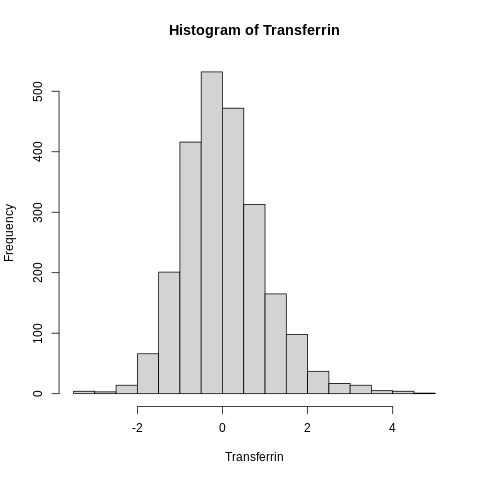

In [36]:
%%R
# Read and display Transferrin phenotype info
tpheno_info <- read_and_display("https://faculty.washington.edu/tathornt/sisg/Tr.pheno", col_names=c("FAMID", "ID", "Transferrin"))
cat("\n--- Summary of Transferrin ---\n")
print(summary(tpheno_info[["Transferrin"]]))
cat("\n--- NA counts in Transferrin ---\n")
print(table(is.na(tpheno_info[["Transferrin"]])))
hist(tpheno_info[["Transferrin"]], xlab="Transferrin", main="Histogram of Transferrin")


--- Head of the Data ---
  FAMID  ID      Height
1   355 883          NA
2   355 884 -1.01219122
3  3004 885 -1.11122366
4  3155 886          NA
5  1629 887 -0.04663134
6  1747 888  1.59969343

--- Dimensions of the Data ---
[1] 4861    3

--- Summary of Height ---
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-4.0274 -0.7340 -0.0299 -0.0204  0.6232  4.5077    2025 

--- NA counts in Height ---

FALSE  TRUE 
 2836  2025 


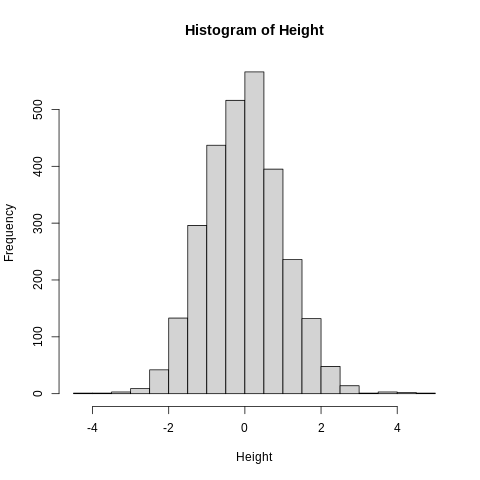

In [39]:
%%R
# Read and display height phenotype info
hpheno_info <- read_and_display("https://faculty.washington.edu/tathornt/sisg/Ht.pheno", col_names=c("FAMID", "ID", "Height"))
cat("\n--- Summary of Height ---\n")
print(summary(hpheno_info[["Height"]]))
cat("\n--- NA counts in Height ---\n")
print(table(is.na(hpheno_info[["Height"]])))
hist(hpheno_info[["Height"]], xlab="Height", main="Histogram of Height")

In [42]:
%%bash

# Download required data files (Replace the LINK placeholders with actual links)
wget https://faculty.washington.edu/tathornt/sisg/Transferrin.bim -O Transferrin.bim
wget https://faculty.washington.edu/tathornt/sisg/Transferrin.fam -O Transferrin.fam
wget https://faculty.washington.edu/tathornt/sisg/Tr.pheno -O Tr.pheno
wget https://faculty.washington.edu/tathornt/sisg/Ht.pheno -O Ht.pheno

# Convert bam to bed
bedtools bamtobed -i Transferrin.fam > sample.bed

###  ASSOCIATION ANALYSIS with Transferrin  Phenotype ###
plink --bfile Transferrin --pheno Tr.pheno --maf 0.05 --geno 0.01 --hwe 0.001 --assoc --out GWAS_T_add

###  ASSOCIATION ANALYSIS with Height Phenotype ###
plink --bfile Transferrin --pheno Ht.pheno --maf 0.05 --geno 0.01 --hwe 0.001 --assoc --out GWAS_H_add

### LD of top association SNPs for Transferrin and Height ###
plink --bfile Transferrin --extract SNPlistTransferrin.txt --r2 --out LD_T_Subset
plink --bfile Transferrin --extract SNPlistHeight.txt --r2 --out LD_H_Subset


PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GWAS_T_add.log.
Options in effect:
  --assoc
  --bfile Transferrin
  --geno 0.01
  --hwe 0.001
  --maf 0.05
  --out GWAS_T_add
  --pheno Tr.pheno

12982 MB RAM detected; reserving 6491 MB for main workspace.
PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to GWAS_H_add.log.
Options in effect:
  --assoc
  --bfile Transferrin
  --geno 0.01
  --hwe 0.001
  --maf 0.05
  --out GWAS_H_add
  --pheno Ht.pheno

12982 MB RAM detected; reserving 6491 MB for main workspace.
PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to LD_T_Subset.log.
Options in effect:
  --bfile Transferrin
  --extract SNPlist

--2023-08-14 03:14:25--  https://faculty.washington.edu/tathornt/sisg/Transferrin.bim
Resolving faculty.washington.edu (faculty.washington.edu)... 128.208.60.35, 140.142.214.168
Connecting to faculty.washington.edu (faculty.washington.edu)|128.208.60.35|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 7787053 (7.4M)
Saving to: ‘Transferrin.bim’

     0K .......... .......... .......... .......... ..........  0%  385K 20s
    50K .......... .......... .......... .......... ..........  1%  800K 14s
   100K .......... .......... .......... .......... ..........  1% 28.6M 10s
   150K .......... .......... .......... .......... ..........  2% 1.79M 8s
   200K .......... .......... .......... .......... ..........  3% 1.36M 8s
   250K .......... .......... .......... .......... ..........  3% 54.2M 6s
   300K .......... .......... .......... .......... ..........  4%  134M 5s
   350K .......... .......... .......... .......... ..........  5% 1.80M 5s
   400K ..........

CalledProcessError: ignored